# LM Language Metadata Visualization
- We generate the language mapping from ISO 639-1 to ISO 639-3 by scrapping `https://en.wikipedia.org/wiki/List_of_ISO_639-2_codes`, for empty ISO 693-3 code, we use the ISO 693-2 code instead
- We also generate CC language data statistics from `https://commoncrawl.github.io/cc-crawl-statistics/plots/languages` with the latest dump on the version `2013-14`
- For other language source, i.e., xP3, ROOTS, mC4, and LLaMA collection, the data is manually collected from the corresponding paper

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lang2vec.lang2vec as l2v
import umap

### Language Metadata from Wiki

In [2]:
meta_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-2_codes')[0]
meta_df.columns = ['639-2', '639-3', '639-5', '639-1', 'lang_name', 'scope', 'type', 'native_name', 'other_name']

In [3]:
meta_df.loc[pd.isna(meta_df['639-3']), '639-3'] = meta_df.loc[pd.isna(meta_df['639-3']), '639-2'].reset_index(drop=True)

In [4]:
meta_df[['639-1', '639-3', 'lang_name', 'native_name', 'other_name', 'scope', 'type']]

,639-1,639-3,lang_name,native_name,other_name,scope,type
0,aa,aar,Afar,Qafaraf; ’Afar Af; Afaraf; Qafar af,NaN,Individual,Living
1,ab,abk,Abkhazian,Аҧсуа бызшәа Aƥsua bızšwa; Аҧсшәа Aƥsua,Abkhaz,Individual,Living
2,NaN,ace,Achinese,بهسا اچيه,Acehnese,Individual,Living
3,NaN,ach,Acoli,Lwo,Acholi,Individual,Living
4,NaN,ada,Adangme,Dangme,Dangme,Individual,Living
...,...,...,...,...,...,...,...
482,NaN,NaN,Zande languages,NaN,NaN,Collective,NaN
483,zu,zul,Zulu,isiZulu,NaN,Individual,Living
484,NaN,zun,Zuni,Shiwi'ma,NaN,Individual,Living
485,NaN,zxx,No linguistic content; Not applicable,NaN,NaN,Special,NaN


### CC Language Source

In [5]:
cc_df = pd.read_html('https://commoncrawl.github.io/cc-crawl-statistics/plots/languages')[0]

In [6]:
cc_df.columns = ['Lang Code', cc_df.columns[1][0], cc_df.columns[2][0], cc_df.columns[3][0]]

In [7]:
# Gathered manually from https://iso639-3.sil.org/code_tables/639/data
cc_unk_lang_map = {
    'bih': 'Bihari languages',
    'crs': 'Seselwa Creole French',
    'lif': 'Limbu',
    'mfe': 'Morisyen',
    '<unknown>': '<unknown>'
}

In [8]:
cc_df['Lang Name'] = cc_df['Lang Code'].apply(
    lambda x: meta_df.loc[meta_df['639-3'] == x, 'lang_name'].values[0] if x in meta_df['639-3'].values else cc_unk_lang_map[x]
)
cc_df.loc[cc_df['Lang Code'] == '<unknown>', 'Lang Code'] = 'zxx'
cc_df['Source'] = 'commoncrawl'
cc_df = cc_df[['Lang Code', 'Lang Name', 'Source']]

# Normalized Other Language Source

In [162]:
dfs = [cc_df]
for path in glob.glob('language_source/*.csv'):
    df = pd.read_csv(path)
    df['Lang Code'] = df['Lang Code'].apply(
        lambda x: meta_df.loc[meta_df['639-1'] == x, '639-3'].values[0] if x in meta_df['639-1'].values else x
    )
    df['Source'] = path.split('/')[-1].split('_lang')[0]
    dfs.append(df)
df = pd.concat(dfs)

In [163]:
df

,Lang Code,Lang Name,Source
0,zxx,<unknown>,commoncrawl
1,aar,Afar,commoncrawl
2,abk,Abkhazian,commoncrawl
3,afr,Afrikaans,commoncrawl
4,aka,Akan,commoncrawl
...,...,...,...
41,xho,Xhosa,roots
42,yor,Yoruba,roots
43,zhs,Chinese (Simplified),roots
44,zht,Chinese (Traditional),roots


In [10]:
unique_lang_code = df['Lang Code'].unique()

### Retrieve Features from URIEL

In [11]:
%%time
# features = [
#     'syntax_wals', 'syntax_sswl', 'syntax_ethnologue', 'syntax_knn', 'syntax_average', 
#     'phonology_wals', 'phonology_average', 'phonology_ethnologue', 'fam', 'geo'
# ]

features = ['syntax_average',  'phonology_average', 'fam', 'geo']
lang_feats = {lang: [] for lang in list(l2v.LANGUAGES)}

for feat in features:
    feats = l2v.get_features(list(l2v.LANGUAGES), feat)
    for lang in lang_feats.keys():
        lang_feats[lang] += feats[lang]

fdf = pd.DataFrame(lang_feats)
fdf[fdf == '--'] = np.nan # Replace '--' column with NaN
fdf = fdf.fillna(0).T # Replace NaN with 0
fdf = fdf.sort_index()
print(fdf.shape)

(4005, 4148)
CPU times: user 1min 3s, sys: 21 s, total: 1min 24s
Wall time: 1min 29s


In [12]:
%%time
umap_mdl = umap.UMAP(low_memory=False)
proj_values = umap_mdl.fit_transform(fdf.values)
fdf['pc1'], fdf['pc2'] = proj_values[:,0], proj_values[:,1]

CPU times: user 3min 23s, sys: 7.62 s, total: 3min 30s
Wall time: 43.7 s


In [122]:
fdf

,0,1,2,3,4,5,6,7,8,9,...,4141,4142,4143,4144,4145,4146,4147,pc1,pc2,category
aaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5430,0.4293,0.4373,0.5168,0.4100,0.4808,0.4605,9.723045,14.138800,Not Supported
aab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5341,0.4157,0.4302,0.5049,0.3989,0.4717,0.4499,9.835763,14.399661,Not Supported
aac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5089,0.5145,0.6094,0.4826,0.5715,0.5505,0.5442,-1.703495,-5.184210,Not Supported
aad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4885,0.4929,0.5881,0.4610,0.5496,0.5291,0.5225,-1.785075,-5.332603,Not Supported
aae,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3722,0.2447,0.2799,0.3352,0.2318,0.3102,0.2838,7.451489,7.215564,Not Supported
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ztu,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.3553,0.4874,0.3443,0.4253,0.4305,0.3719,0.4062,13.226818,-4.705648,Not Supported
zty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.3535,0.4851,0.3419,0.4234,0.4281,0.3697,0.4040,13.078446,-4.900360,Not Supported
zul,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0,...,0.7312,0.5770,0.6445,0.6763,0.5895,0.6719,0.6407,6.859855,15.735495,Supported
zun,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.2423,0.3881,0.2560,0.3138,0.3399,0.2691,0.3055,10.920843,-2.174880,Not Supported


CPU times: user 4.24 s, sys: 845 ms, total: 5.08 s
Wall time: 5.01 s


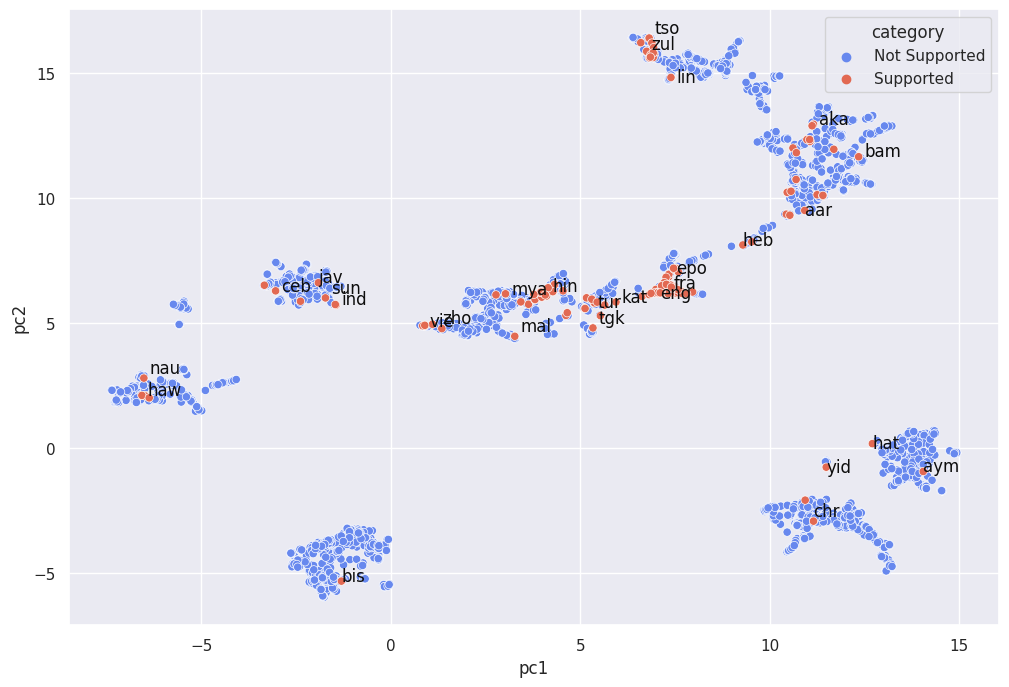

In [161]:
%%time
sns.set(rc={'figure.figsize':(12,8)})
fdf['category'] = fdf.index.isin(unique_lang_code)
fdf['category'] = fdf['category'].apply(lambda x: 'Supported' if x else 'Not Supported')

cw_palette = sns.color_palette("coolwarm")
render_palette = sns.color_palette([cw_palette[0], cw_palette[-1]])
sns.scatterplot(fdf.sort_values('category'), x='pc1', y='pc2', hue='category', palette=render_palette)

def label_point(xs, ys, vals, ax):
    np.random.seed(512)
    for x, y, val in zip(xs, ys, vals):
        if val == 'fra':
            ax.text(x + 0.15, y + 0.2, str(val), color='#0d0d0d')
        else:
            ax.text(x + (np.random.choice([0, 1]) * 0.15), y - (np.random.choice([-1, 0, 1]) * 0.2), str(val), color='#0d0d0d')

lang_filter = [
    'eng', 'slo', 'slo', 'jap', 'zho', 'ind', 'vie', 'aka', 'mya', 'tgk', 'jav',
    'haw', 'nau', 'bis', 'chr', 'hat', 'aym', 'tso', 'bam', 'aar', 'fas', 'yid',
    'ceb', 'heb', 'hin', 'zul', 'fra', 'tur', 'epo', 'kat', 'sun', 'mal', 'lin', 
]
# lang_filter = unique_lang_code[::8]

lang_list = list(fdf.index)
filt_lang_list = [lang if lang in lang_filter else '' for lang in lang_list]
label_point(fdf['pc1'], fdf['pc2'], filt_lang_list, plt.gca())
plt.savefig('LM-supported.png', bbox_inches='tight')

### Language Family Distribution

In [191]:
fam_feats = np.load('family_features.npz')
lang_fams = [
    'Atlantic-Congo', 'Austronesian', 'Indo-European', 'Sino-Tibetan', 'Bookkeeping', 'Afro-Asiatic' 'Pama-Nyungan',
    'Sign Language', 'Otomanguean', 'Austroasiatic', 'Unclassifiable', 'Tai-Kadai', 'Pidgin', 'Dravidian'
]
f_lang_fams = list(map(lambda l: f'F_{l}', lang_fams))

idx2fam = {}
for i, feat in enumerate(fam_feats['feats']):
    if feat in f_lang_fams:
        idx2fam[i] = feat

In [203]:
%%time
fam_feats = {lang: [] for lang in list(l2v.LANGUAGES)}
l2v_fam_feats = l2v.get_features(list(l2v.LANGUAGES), 'fam')
for lang in fam_feats.keys():
    fam_feats[lang] = np.array(l2v_fam_feats[lang])[list(idx2fam.keys())]

fam_df = pd.DataFrame(fam_feats)
fam_df[fam_df == '--'] = np.nan # Replace '--' column with NaN
fam_df = fam_df.fillna(0).T # Replace NaN with 0
fam_df = fam_df.sort_index()
print(fam_df.shape)

(4005, 11)
CPU times: user 20.6 s, sys: 1.09 s, total: 21.6 s
Wall time: 21.7 s


In [214]:
fam_df.columns = idx2fam.values()
fam_count_df = fam_df.sum().reset_index()

In [217]:
fam_count_df

,index,0
0,F_Austronesian,604.0
1,F_Atlantic-Congo,671.0
2,F_Indo-European,272.0
3,F_Sino-Tibetan,203.0
4,F_Dravidian,38.0
5,F_Austroasiatic,66.0
6,F_Tai-Kadai,27.0
7,F_Otomanguean,100.0
8,F_Sign Language,55.0
9,F_Unclassifiable,4.0
